# Get sigma_density for stars with spectroscopy

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import csv
plt.rcParams['figure.figsize'] = [10, 5]

## Calculate rho

We want to calculate rho (which takes in mass and radius) for each isochrone.

In [51]:
def solar_density():
    #Define Solar density for 1 Msol and 1 Rsol in kg/m3
    sol_density = ((1.*1.989e30)/((4./3.)*np.pi*1.**3*696.34e6**3))
    return sol_density

def find_density_dist(mass_dist, rad_dist, norm=None):
    
    rho_dist = np.zeros(len(mass_dist))

    #for point from 0 to len(isochrones)
    #Adding each density point to rho_dist
    for point in range(len(mass_dist)):
        rho_dist[point] = density(mass_dist[point], rad_dist[point], norm=norm)
    
    return rho_dist

def density(mass, radius, norm=None):
    """Mass in solar density
    Radius in solar density
    sol_density in kg/m^3"""
    
    if norm==None:
        return ((mass*1.989e30)/((4./3.)*np.pi*radius**3*696.34e6**3))
    else:
        return ((mass*1.989e30)/((4./3.)*np.pi*radius**3*696.34e6**3))/float(norm)

def iso_lists(path):
    iso_lst = []
    files = glob.glob(path)
    for f in files:
        iso_lst.append(pd.read_csv(f))
    return iso_lst


def dict_rhos(isos):
    dict = {}
    for i in range(len(isos)):
        kic = isos[i].KIC[0]
        dict["{0}".format(kic)] = find_density_dist(np.array(isos[i].mstar), np.array(isos[i].radius))
    return dict


def rho_dict_to_csv(rho_dict, filename):
    pd.DataFrame.from_dict(rho_dict, orient='index').transpose().to_csv(filename, index=False)

In [6]:
iso_fits = iso_lists('isochrone_fits/spectroscopy/*.csv')
iso_fits_lum = iso_lists('isochrone_fits/spectroscopy_luminosity/*.csv')

In [7]:
rhos_spec = [find_density_dist(np.array(iso_fits[i].mstar), np.array(iso_fits[i].radius)) for i in range(len(iso_fits))]

In [8]:
rhos_lum = [find_density_dist(np.array(iso_fits_lum[i].mstar), np.array(iso_fits_lum[i].radius)) for i in range(len(iso_fits_lum))]

In [43]:
rho_spec = dict_rhos(iso_fits)

In [44]:
rho_lum = dict_rhos(iso_fits_lum)

Save rho distributions for each star to csv

In [52]:
rho_dict_to_csv(rho_spec, 'rho_spec.csv')
rho_dict_to_csv(rho_lum, 'rho_lum.csv')

# Find sigma_rho

In [363]:
def get_cdf(dist, nbins=100):
    counts, bin_edges = np.histogram(dist, bins=nbins, range=(np.min(dist), np.max(dist)))
    cdf = np.cumsum(counts)
    cdf = cdf/np.max(cdf)
    return bin_edges[1:], cdf

def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return int(np.where(array == array[idx])[0])

def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if len(np.where(array == array[idx])[0]) == 1:
        return int(np.where(array == array[idx])[0])
    else:
        return int(np.where(array == array[idx])[0][0])

def find_sigma(x, cdf, sign):
    med = x[find_nearest_index(cdf, 0.5)]
    if sign == "-":
        sigma = x[find_nearest_index(cdf, 0.16)] - med
    elif sign == "+":
        sigma = x[find_nearest_index(cdf, 0.84)] - med
    return sigma

def plot_cdf(x, cdf):
    plt.plot(x, cdf)
    plt.axvline(x=x[find_nearest_index(cdf, 0.5)], c='r', label='Median')
    plt.axvline(x=x[find_nearest_index(cdf, 0.5)]+find_sigma(x, cdf, "-"), c='blue', label='- sigma')
    plt.axvline(x=x[find_nearest_index(cdf, 0.5)]+find_sigma(x, cdf, "+"), c='orange', label='+ sigma')
    plt.legend()
    plt.xlabel('Density')
    
    
def iterate_stars(rho_dict): 
    for key, val in rho_dict.items():
        x, cdf = get_cdf(rho_spec[key])
        sigma_minus = find_sigma(x, cdf, "-")
        sigma_plus = find_sigma(x, cdf, "+")
        
        df = pd.DataFrame({"x" : x, "cdf" : cdf, "sigma_minus": sigma_minus, "sigma_plus": sigma_plus})
        df.to_csv("cdfs/cdf_lum/cdf_lum_" + str(key) + ".csv", index=False)

In [362]:
iterate_stars(rho_spec)

In [364]:
iterate_stars(rho_lum)

## Pull sigmas from CSVs and plot

In [365]:
cdf_spec = iso_lists('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Code/cdfs/cdf_spec/*.csv')
cdf_lum = iso_lists('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Code/cdfs/cdf_lum/*.csv')

In [366]:
sigma_minus_spec = [cdf_spec[x].sigma_minus[0] for x in range(len(cdf_spec))]
sigma_plus_spec = [cdf_spec[x].sigma_plus[0] for x in range(len(cdf_spec))]

sigma_minus_lum = [cdf_lum[x].sigma_minus[0] for x in range(len(cdf_lum))]
sigma_plus_lum = [cdf_lum[x].sigma_plus[0] for x in range(len(cdf_lum))]

Text(0.5, 1.0, '')

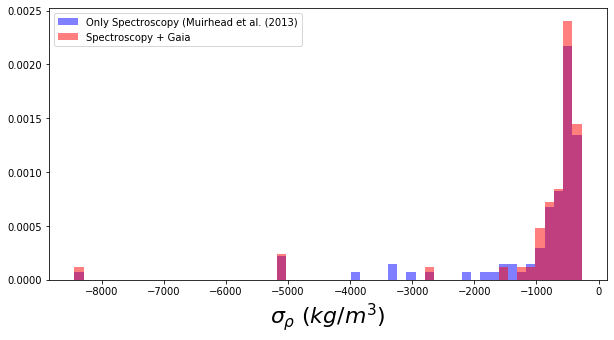

In [408]:
plt.hist(sigma_minus_spec, bins=55, density=True, color='blue', label='Only Spectroscopy (Muirhead et al. (2013)', alpha=0.5);
plt.hist(sigma_minus_lum, bins=55, density=True, color='red', label='Spectroscopy + Gaia', alpha=0.5);
plt.legend()
plt.xlabel(r"$\sigma_{\rho}$ $(kg/m^3)$", size=22)
plt.title("")

In [371]:
sigma_minus_spec[0:10]

[-431.03359129979714,
 -5033.382010759262,
 -8443.499354015294,
 -707.8733192754089,
 -449.58080926300414,
 -3271.010042862108,
 -590.1067347837734,
 -695.9755188634234,
 -291.62714416305516,
 -3857.3648273075614]

In [373]:
sigma_minus_lum[0:10]

[-431.03359129979714,
 -599.8463217738072,
 -467.5330176142188,
 -1057.382449614901,
 -517.3585076603795,
 -382.6772484170815,
 -852.7961026013309,
 -578.5999676349802,
 -555.4165541599505,
 -456.84901166309373]

## Extra (Comparing sigma from spectroscopy to sigma from spectroscopy + Gaia)

Text(0.5, 0, 'Density (kg/m^3)')

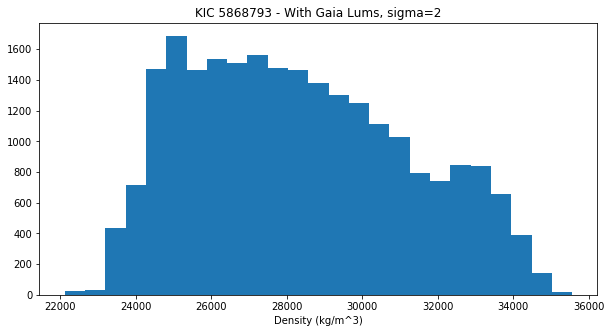

In [320]:
df1 = pd.read_csv(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Code/isochrone_fits/spectroscopy_luminosity/iso_lums_5868793.csv')
rho5868793 = find_density_dist(np.array(df1.mstar), np.array(df1.radius))
plt.hist(rho5868793, bins=25);
plt.title('KIC 5868793 - With Gaia Lums, sigma=2')
plt.xlabel('Density (kg/m^3)')

Text(0.5, 0, 'Density (Sol Density)')

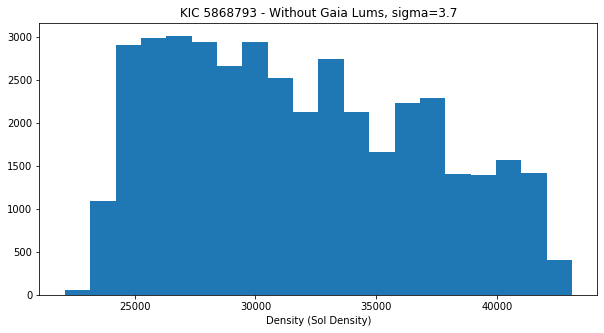

In [321]:
dfnolum = pd.read_csv(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Code/isochrone_fits/spectroscopy/iso_fits_5868793.csv')
rho5868793nolum = find_density_dist(np.array(dfnolum.mstar), np.array(dfnolum.radius))
plt.hist(rho5868793nolum, bins=20);
plt.title('KIC 5868793 - Without Gaia Lums, sigma=3.7')
plt.xlabel('Density (Sol Density)')